# Actor-Critic in TensorFlow

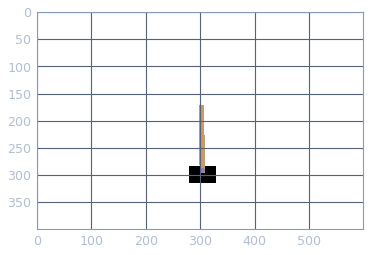

In [1]:
import gym
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")


env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [2]:
class PolicyValueApproximator(Model):
    def __init__(self, action_dim):
        super().__init__()
        self.d1 = Dense(32, activation='relu', name='dense1')
        self.d2 = Dense(16, activation='relu', name='dense2')
        self.d3_policy = Dense(2, activation='relu', name='dense_policy')
        self.d3_value = Dense(1, activation='linear', name='dense_value')

    def __call__(self, x):
        x = self.d1(x)
        x = self.d2(x)
        policy = self.d3_policy(x)
        value = self.d3_value(x)
        return [value, policy]
        
    def model(self):
       # x = Input(shape=(4, ))
        x = Input(shape=(4,))
        return Model(inputs=x, outputs=self(x))

In [3]:
tf.keras.backend.clear_session()
policy_value_approximator = PolicyValueApproximator(action_dim=n_actions)

# Your code: define optimizers
optimizer = tf.keras.optimizers.Adam()
policy_value_approximator.model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 32)           160         input_1[0][0]                    
__________________________________________________________________________________________________
dense2 (Dense)                  (None, 16)           528         dense1[0][0]                     
__________________________________________________________________________________________________
dense_value (Dense)             (None, 1)            17          dense2[0][0]                     
______________________________________________________________________________________________

In [4]:
policy_value_approximator(np.reshape(env.reset().astype('float32'), (1, 4)))

[<tf.Tensor: id=143, shape=(1, 1), dtype=float32, numpy=array([[-0.00542283]], dtype=float32)>,
 <tf.Tensor: id=139, shape=(1, 2), dtype=float32, numpy=array([[0.0061877, 0.       ]], dtype=float32)>]

In [25]:
policy_value_approximator.trainable_variables

[<tf.Variable 'dense1/kernel:0' shape=(4, 32) dtype=float32, numpy=
 array([[-0.21471545, -0.30401823,  0.2201537 , -0.13353506,  0.01762212,
         -0.03336084, -0.14911483, -0.00531427,  0.15315236,  0.4068918 ,
         -0.16688442,  0.08944829, -0.17637153,  0.36296695, -0.0882881 ,
          0.30591798,  0.28081745, -0.17722386, -0.34958377, -0.05544568,
          0.08570537,  0.08991198,  0.39227292, -0.02545653,  0.35692555,
          0.37560666, -0.27415413, -0.30635208,  0.04854113, -0.39952987,
          0.12690419, -0.375425  ],
        [ 0.32559037, -0.34090972,  0.07306491,  0.20169626,  0.22415589,
         -0.14581263,  0.33016375, -0.07534275, -0.26816827,  0.11105263,
         -0.36362088,  0.07719202, -0.02258976, -0.15734988,  0.23373282,
         -0.16440609,  0.12713397,  0.36122423,  0.10219144,  0.00365867,
          0.40643978, -0.3809655 ,  0.05943088, -0.15794407, -0.14035696,
          0.08797608,  0.02872825,  0.06389271, -0.29589406, -0.40435645,
        

In [5]:
def policy(states):
    return tf.nn.softmax(policy_value_approximator(states)[1])

def log_policy(states):
    return tf.nn.log_softmax(policy_value_approximator(states)[1])

def get_action_probs(states):
    log_action_probs = tf.squeeze(log_policy(states), 0)
    action_probs = tf.squeeze(policy(states), 0)
    return log_action_probs, action_probs

def compute_entropy(action_probs, log_action_probs):
    return - tf.math.reduce_sum(tf.math.multiply(action_probs, log_action_probs))

### Playing the game

In [ ]:
trunk = tf.keras.Sequential([...])
head1 = tf.keras.Sequential([...])
head2 = tf.keras.Sequential([...])

path1 = tf.keras.Sequential([trunk, head1])
path2 = tf.keras.Sequential([trunk, head2])

# Train on primary dataset
for x, y in main_dataset:
  with tf.GradientTape() as tape:
    prediction = path1(x)
    loss = loss_fn_head1(prediction, y)
  # Simultaneously optimize trunk and head1 weights.
  gradients = tape.gradient(loss, path1.trainable_variables)
  optimizer.apply_gradients(zip(gradients, path1.trainable_variables))

# Fine-tune second head, reusing the trunk
for x, y in small_dataset:
  with tf.GradientTape() as tape:
    prediction = path2(x)
    loss = loss_fn_head2(prediction, y)
  # Only optimize head2 weights, not trunk weights
  gradients = tape.gradient(loss, head2.trainable_variables)
  optimizer.apply_gradients(zip(gradients, head2.trainable_variables))

# You can publish just the trunk computation for other people to reuse.
tf.saved_model.save(trunk, output_path)

In [19]:
def train_step(state_previous, state, action, reward, gamma=0.99, entropy_coef=1e-2):
    
    # Environment step
    
    # Gradient descent step  
    with tf.GradientTape(persistent=True) as tape:
        s_prev = tf.Variable(state_previous, dtype='float32', name='state_prev')
        s = tf.Variable(state, dtype='float32', name='state')
        a = tf.Variable(action, dtype='int32', name='action')
        r = tf.Variable(reward, dtype='float32', name='reward')
        
        # Get the policy and value function prediction
        v_s = policy_value_approximator(s)[0]
        v_s_prev = policy_value_approximator(s_prev)[0]
        
        # Compute policy for a gradient update step
        p_s = policy_value_approximator(s)[1]
        
        # Compute action probs
        log_action_probs, action_probs = get_action_probs(s)
        
        # Compute entropy
        entropy = compute_entropy(log_action_probs, action_probs)
        
        # Compute error
        delta = r + gamma * v_s - v_s_prev
    
    # Optimise the net and the policy output weights
    gradients_policy = tape.gradient(delta, policy_value_approximator.trainable_variables[:6])
    optimizer.apply_gradients(zip(gradients_policy, policy_value_approximator.trainable_variables[:6]))      
    
    # Optimise the net and the policy output weights
    gradients_value = tape.gradient(delta, policy_value_approximator.trainable_variables[6:8])
    optimizer.apply_gradients(zip(gradients_value, policy_value_approximator.trainable_variables[6:8]))      



In [20]:
s = env.reset().astype('float32')

In [21]:
v, p = policy_value_approximator(np.reshape(s, (1, 4)))

In [22]:
def generate_session(t_max=1000):
    
    # arrays to record session
    states, actions, rewards = np.asarray([], dtype='float32'), [], []

    s_prev = env.reset().astype('float32')
    
    for t in range(t_max):

        # action probabilities and log probabilities
        log_action_probs, action_probs = get_action_probs(np.reshape(s_prev, (1, 4)))
        log_action_probs = log_action_probs.numpy().reshape(2,)
        action_probs = action_probs.numpy().reshape(2,)
        # choose an action
        a = np.random.choice([0, 1], p=action_probs)
        # perform a step
        s, r, done, info = env.step(a)
        
        # perform a train step
        train_step(state_previous=np.reshape(s_prev, (1, 4)), state=np.reshape(s, (1, 4)), action=a, reward=r)
        
        # record session history to train later
        states = np.concatenate((states, s), axis=0)
        actions.append(a)
        rewards.append(r)

        s_prev = s.astype('float32')
        
        if done:
            break
            
    return states.reshape(-1, s.shape[0]), actions, rewards
    

In [23]:
tf.keras.backend.clear_session()
policy_value_approximator = PolicyValueApproximator(action_dim=n_actions)

# Your code: define optimizers
optimizer = tf.keras.optimizers.Adam()

In [24]:
global_rewards = []

for i in range(10000):

    _, _, rewards = generate_session() # generate new sessions
    global_rewards.append(rewards)
    
    if i % 100 == 0:
        print("Episode number {} and the reward is {}".format(i, np.mean(global_rewards[-100:])))

    if np.mean(global_rewards[-100:]) > 300:
        print("You Win!")
        break

Episode number 0 and the reward is 1.0


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [27]:
policy_approximator.save_weights('model_weights/trained_policy_actor_critic')

### Results & video

In [28]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos_ac", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [30]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos_ac/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices